# Smoothing methods
Smoothing methods for prediction (exponential smoothing)

In [1]:
# Libraries

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from random import gauss
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from random import random
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})  

Exponential Moving Average (EMA) assigns exponentially decreasing weights over time. Low pass filter that removes high-frequency noise. 

Exponential smoothing methods can be formulated as special case of a general framework called state space models.

## Popular methods

### EMWA

Simple Exponential Smoothing (Brown method) is defined by the relationship:

\begin{equation}
S_t = \alpha X_t + (1-\alpha) S_{t-1} \quad \text{where} \quad \alpha \in (0,1)
\end{equation}

or equivalently:

\begin{equation}
S_t = S_{t-1} + \alpha  (X_t - S_{t-1})
\end{equation}

Few observations around that definition:
* the smoothed series is a simple weighted average of the past and the present 
* interpretation of smoothing factor $\alpha$: recency vs smoothing (see below). It defines how quickly we will "forget" the last available true observation.
* $\alpha$ is selected on the basis of expert judgement or estimated (with MSE); statsmodels does the estimation by default
* by its very nature, smoothing needs some time to catch up with the dynamics of your time series. A rule of thumb for a reasonable sample size is that you need $\frac{3}{\alpha}$ observations.
* Exponentiality is hidden in the recursiveness of the function -- we multiply by  $(1−\alpha)$  each time, which already contains a multiplication by the same factor of previous model values.
* the method is suitable for forecasting data with no clear trend or seasonal pattern

With the setup of the above equation, we have the following form of a long term forecast:
\begin{equation}
\hat{X}_{t+h} = S_t
\end{equation}

which means simply that out of sample, our forecast is equal to the most recent value of the smoothed series.

It's an old cliche that a picture is worth a thousand words - so the three pictures below should give you a truly excellent intuition ;-) on how single exponential smoothing works. 

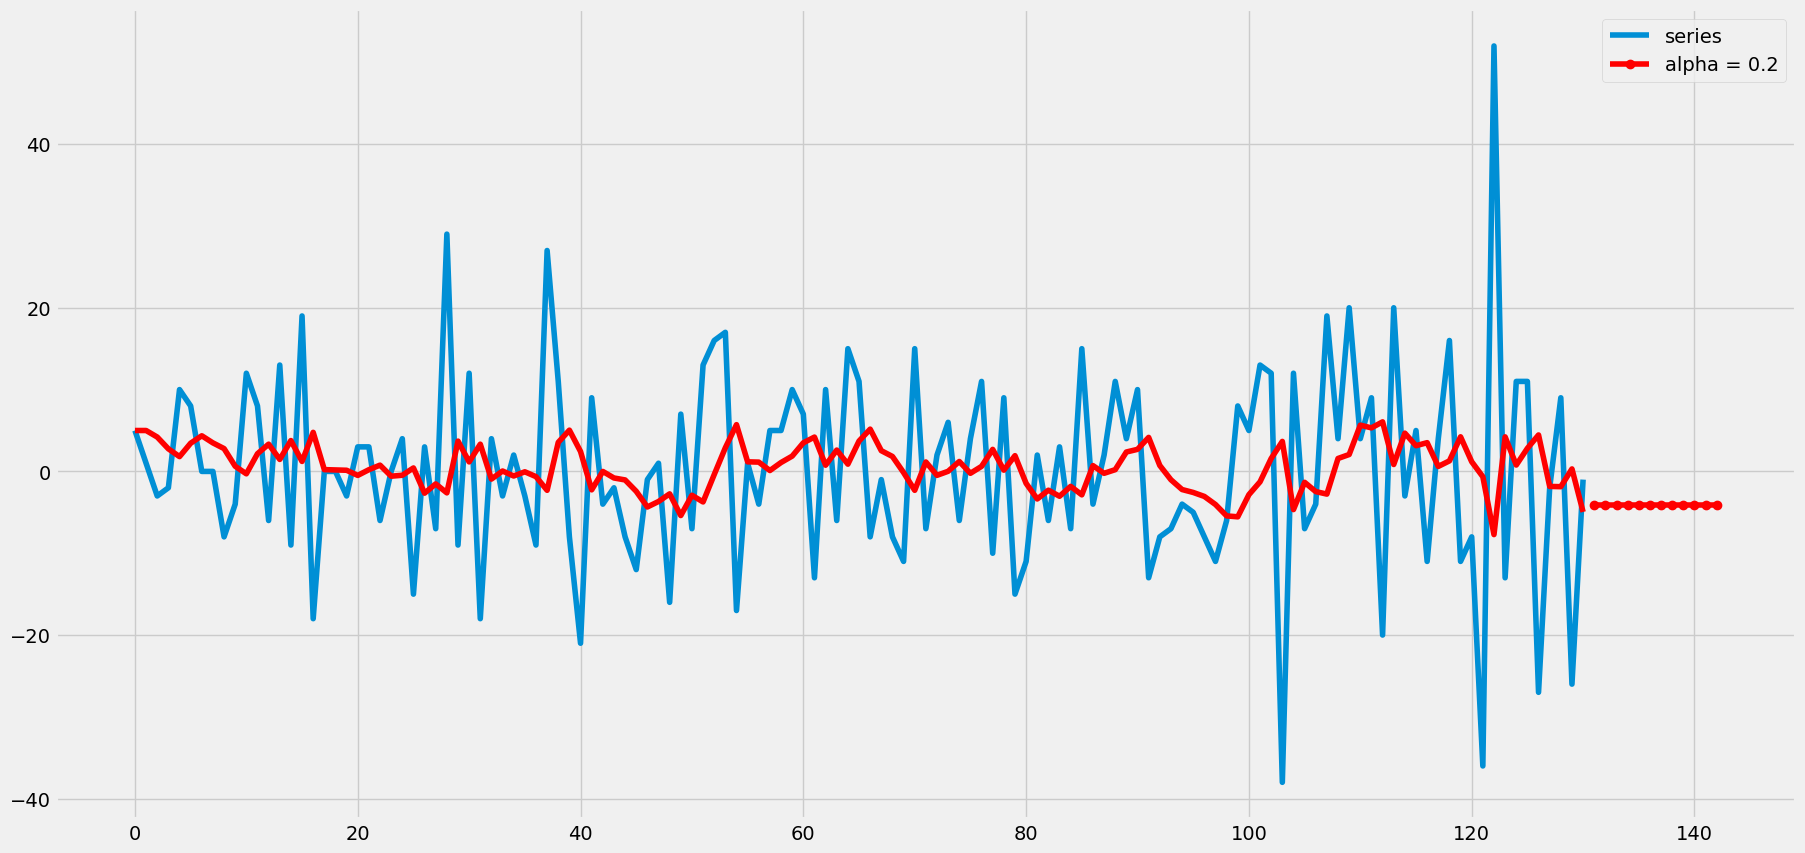

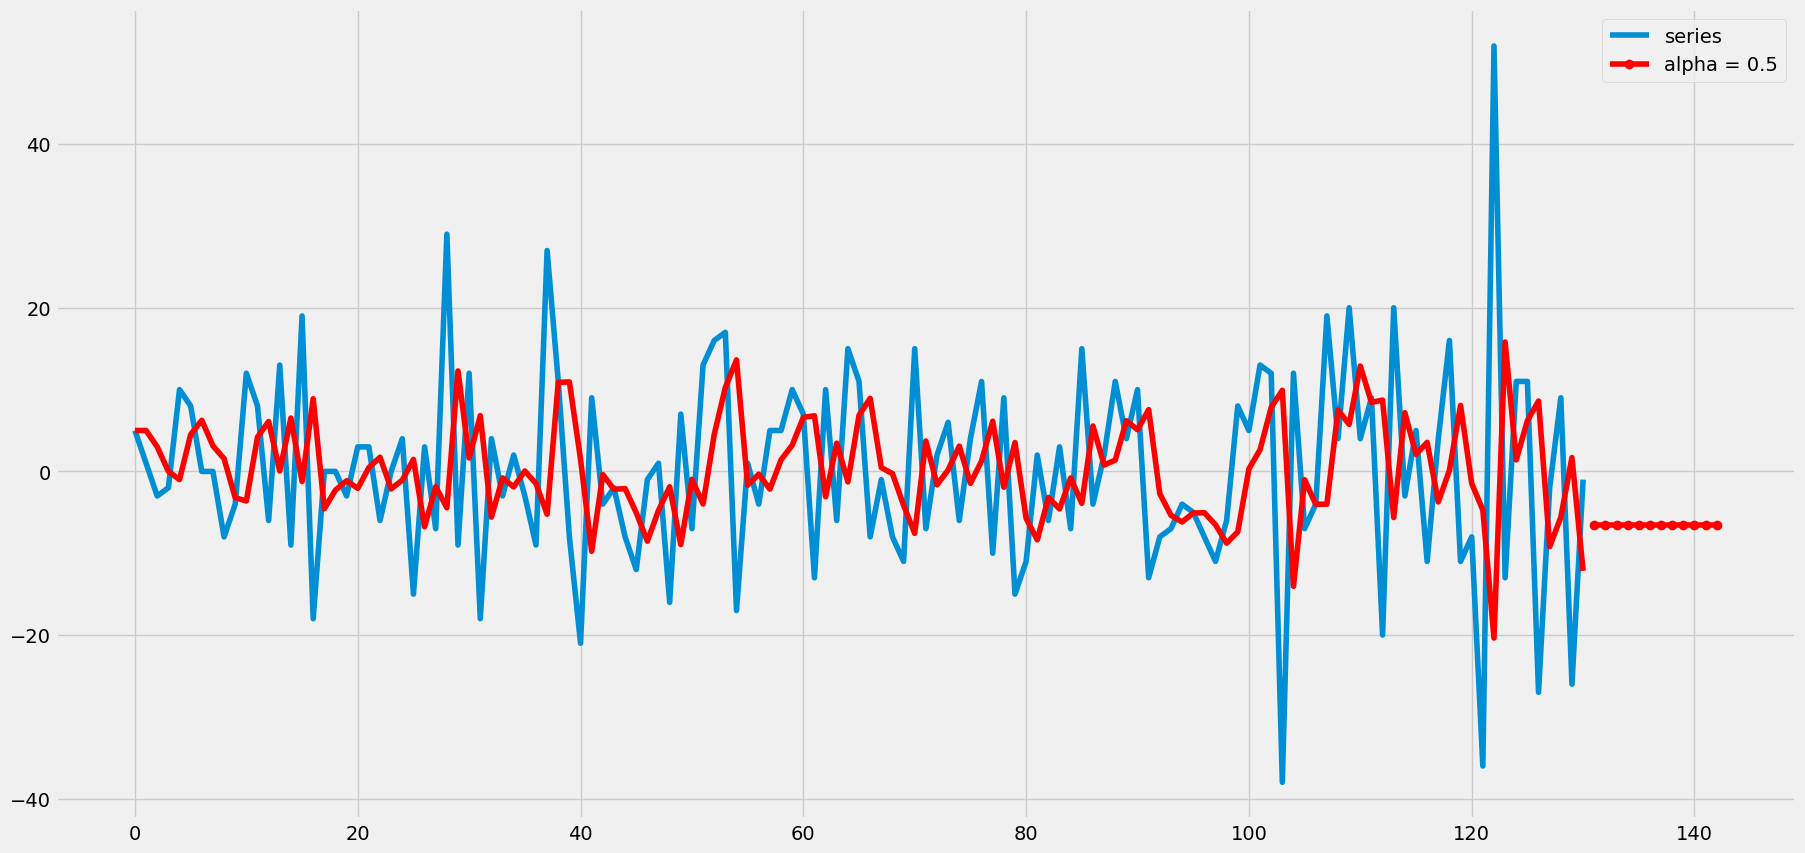

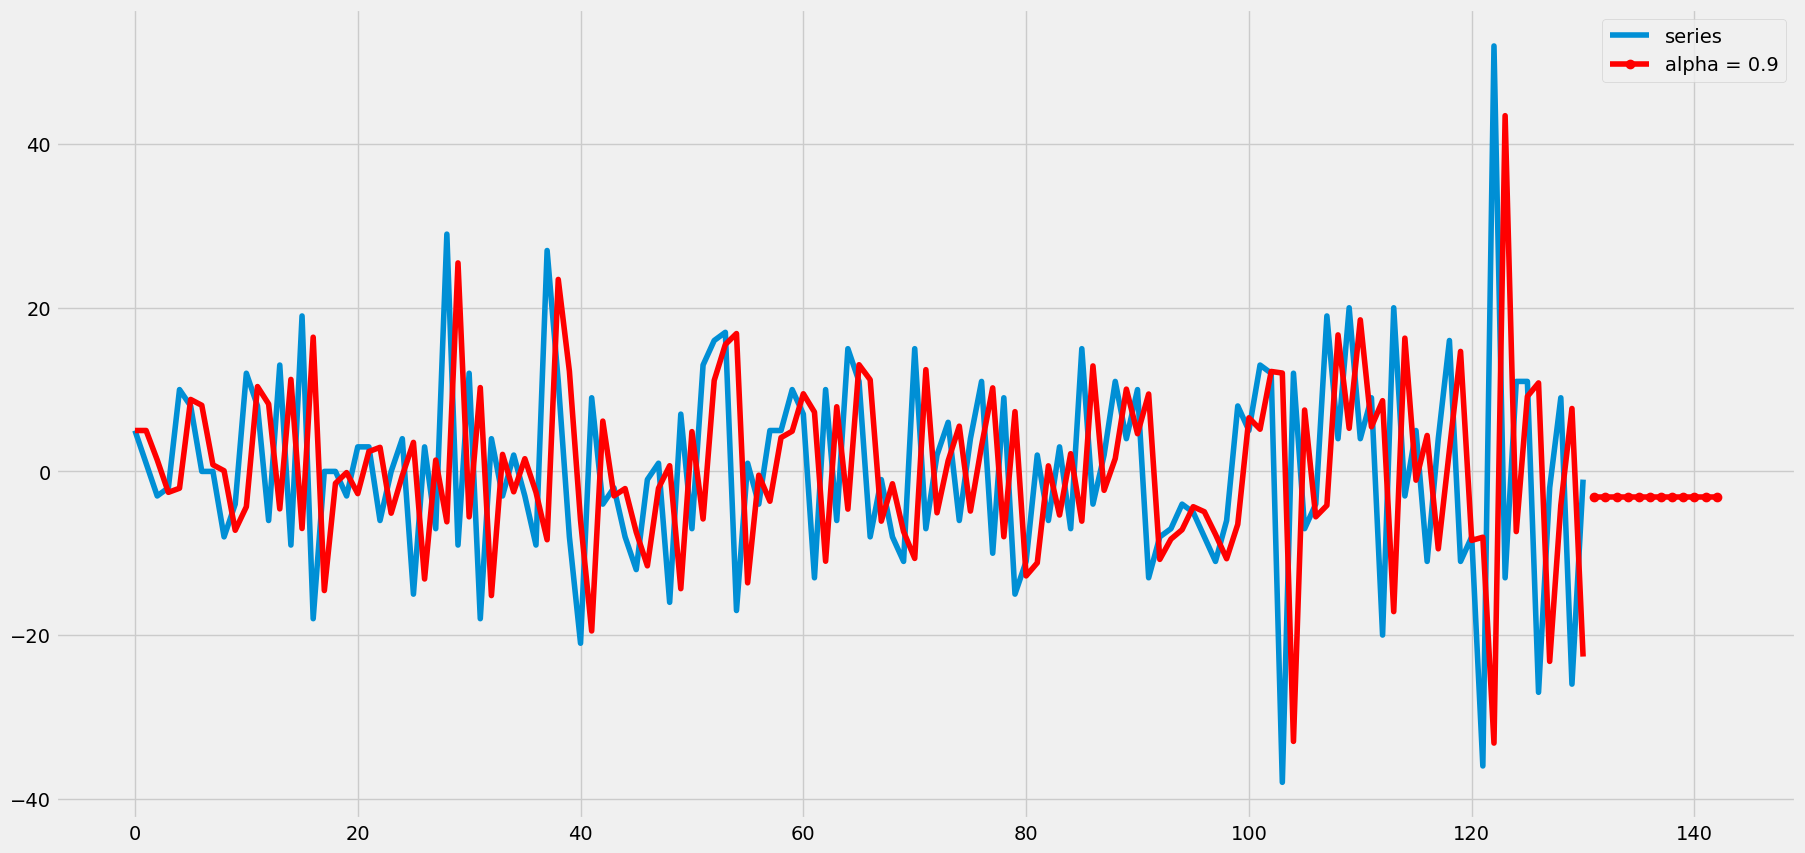

In [3]:
for alpha_sm in [0.2 , 0.5, 0.9]:

    df = pd.read_csv(CFG.data_folder + 'exp1.csv', header = None); df.columns = ['series'] # Escoger la base de datos y las columnas de interes
    df.plot.line() # Grafica de la serie
    fit1 = SimpleExpSmoothing(df).fit(smoothing_level = alpha_sm  ,optimized=False) # Funcion necesaria para realizar el exponential smoothing
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm)) # Realizar el forecast a 12 pasos de la serie a la que se realizo exponential
    fcast1.plot(marker='o', color='red', legend=True) # Graficar el forecast 
    fit1.fittedvalues.plot(  color='red') # Graficar la serie estimada con el exponential smoothing
    plt.show() # Mostrar el grafico

As you can see from the graphs above, the for small values of the smoothing constant $\alpha$ most of the variation has been removed and we have a series following just the general trend; on the other hand, high value of the $\alpha$ parameter results in hardly any smoothing at all and the new series follows the original very closely (albeit with a delay, which is obvious given the relationship between raw and smoothed values).


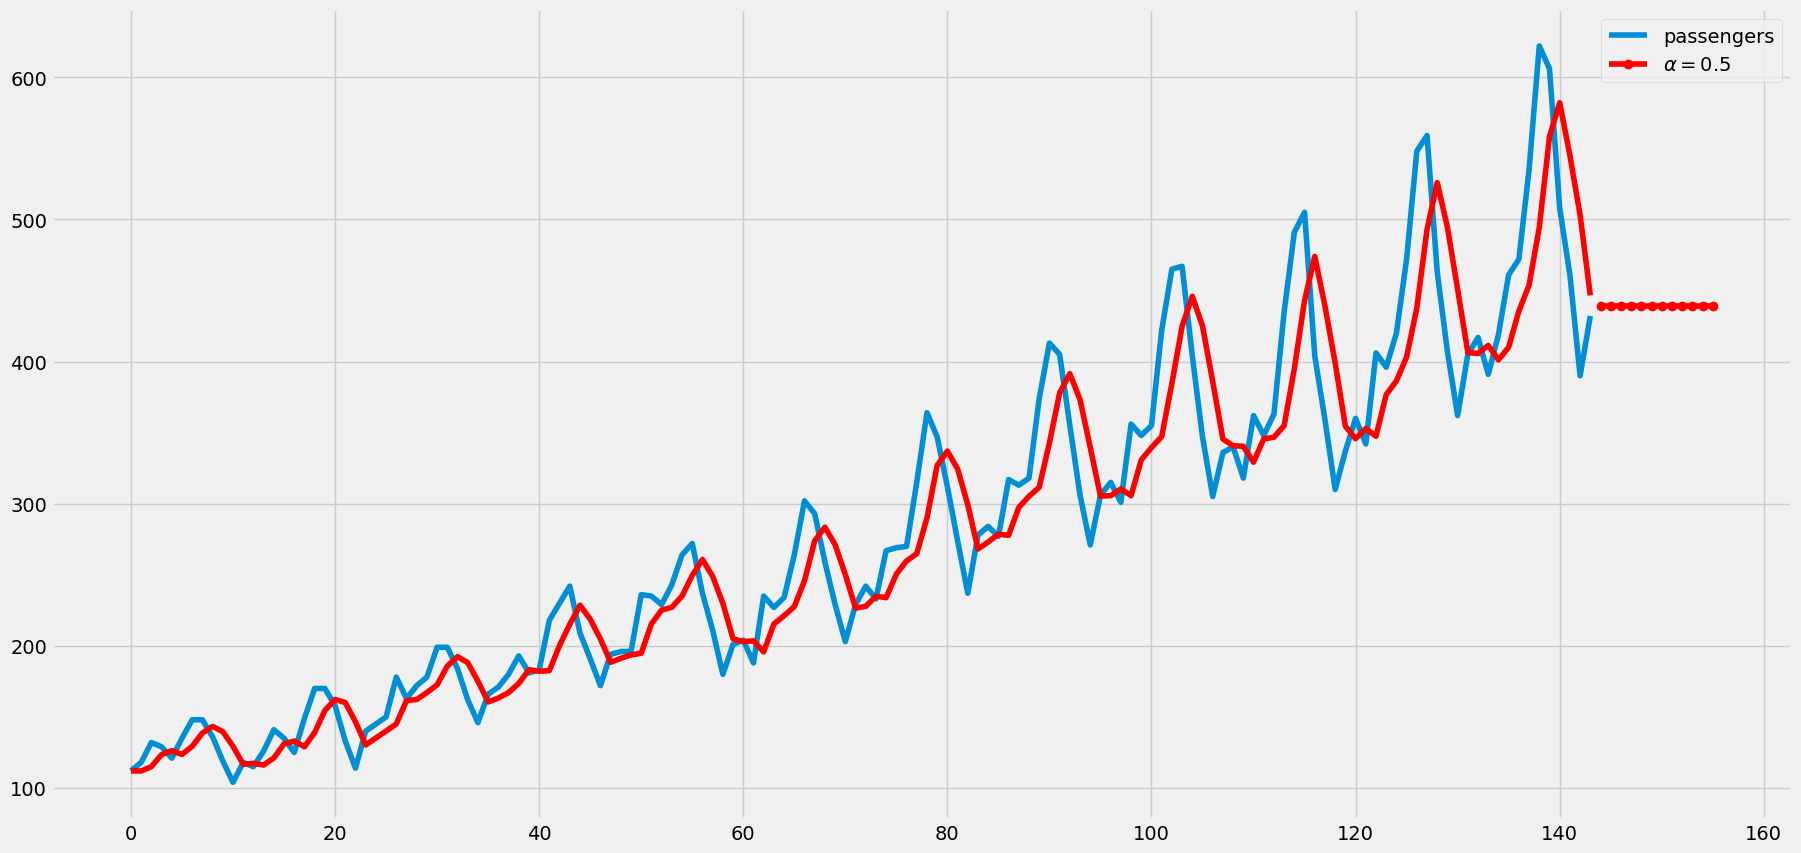

In [4]:
alpha = 0.5

df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers']) # otra forma de seleccionar las columnas de interes
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

On the one hand, the model does exactly what we expect it to do: beyond the range of the original data, it propagates the most recent smoothed value. On the other hand - it is not, to put it mildly, realistic to expect the number of passengers to flatline and the trend to disappear.


## Double Exponential Smoothing

Moving towards double exponential smoothing is akin to taking one more component in the seasonal decomposition: we began with level only, and we take into account the trend as well. We have learnt to predict intercept with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes.  Double exponential smoothing, a.k.a. the Holt method is defined by the relationship:

\begin{equation}
S_t = \alpha X_t + (1 - \alpha) (S_{t-1} + b_{t-1})\\
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1}
\end{equation}

where $S_1 = X_1$, $\quad b_1 = X_1 - X_0$ and $\alpha, \beta \in (0,1)$

The first equation describes the intercept, which depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. Complete prediction is composed of the sum of level and trend and the difference with simple exponential smoothing is that we need a second parameter to smooth the trend - as before, those can be set based on expert judgement or estimated (jointly) from the data. 

The forecast $h$ steps ahead is defined by
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t
\end{equation}

The forecast function is no longer flat but trending: $h$-step-ahead forecast is equal to the last estimated level plus $h$ times the last estimated trend value.

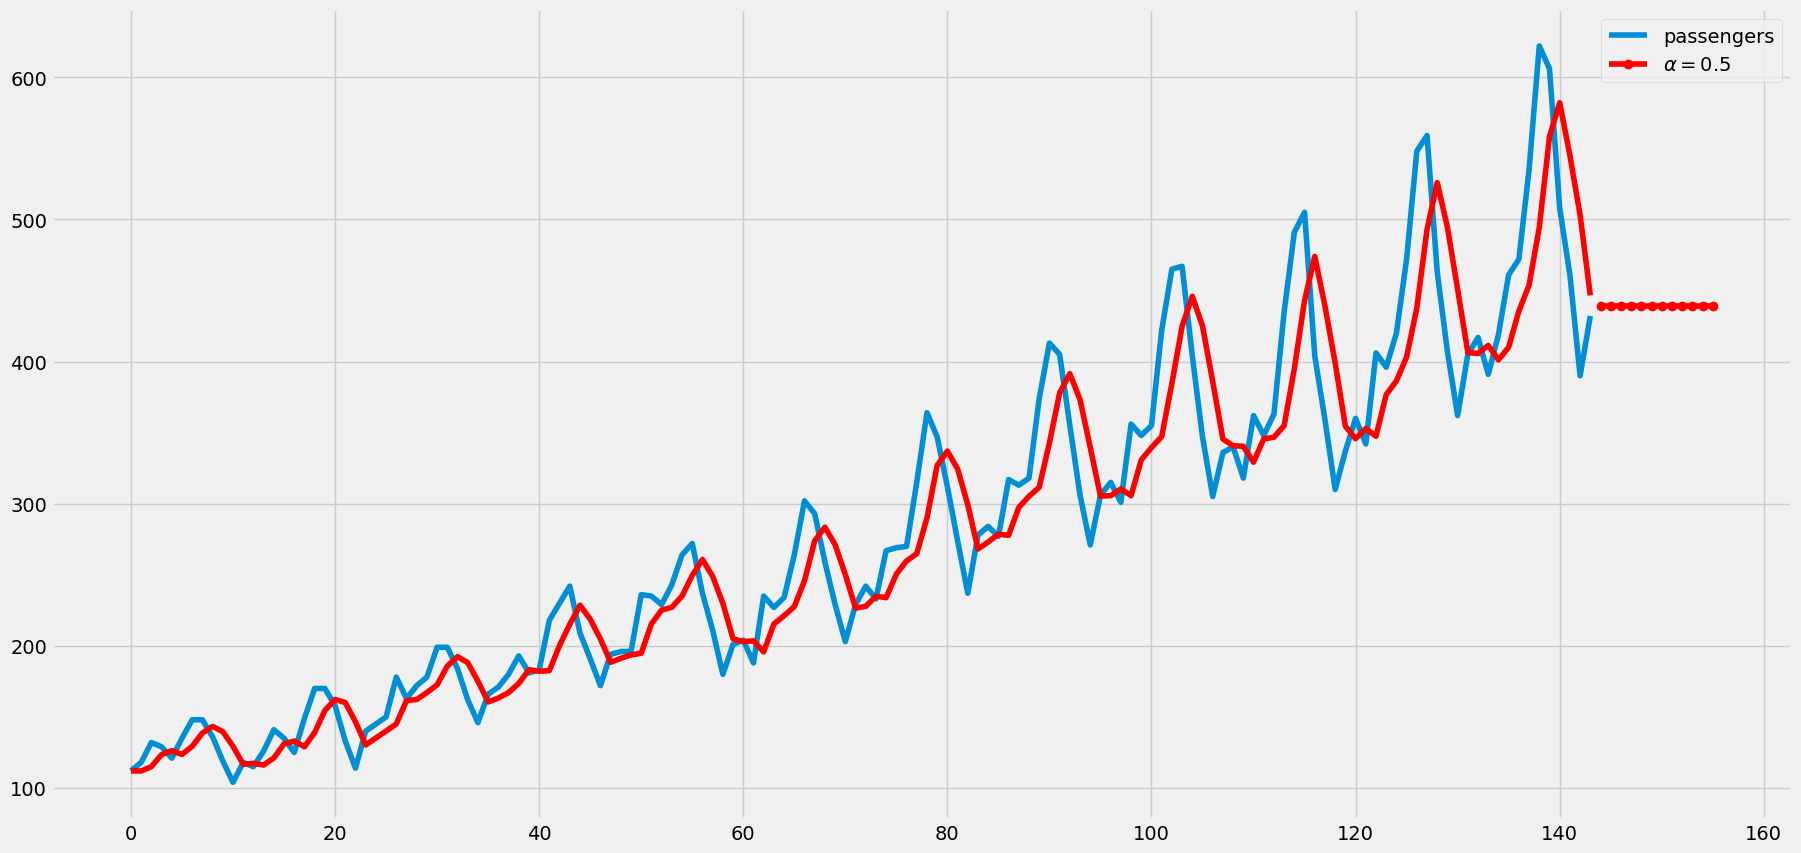

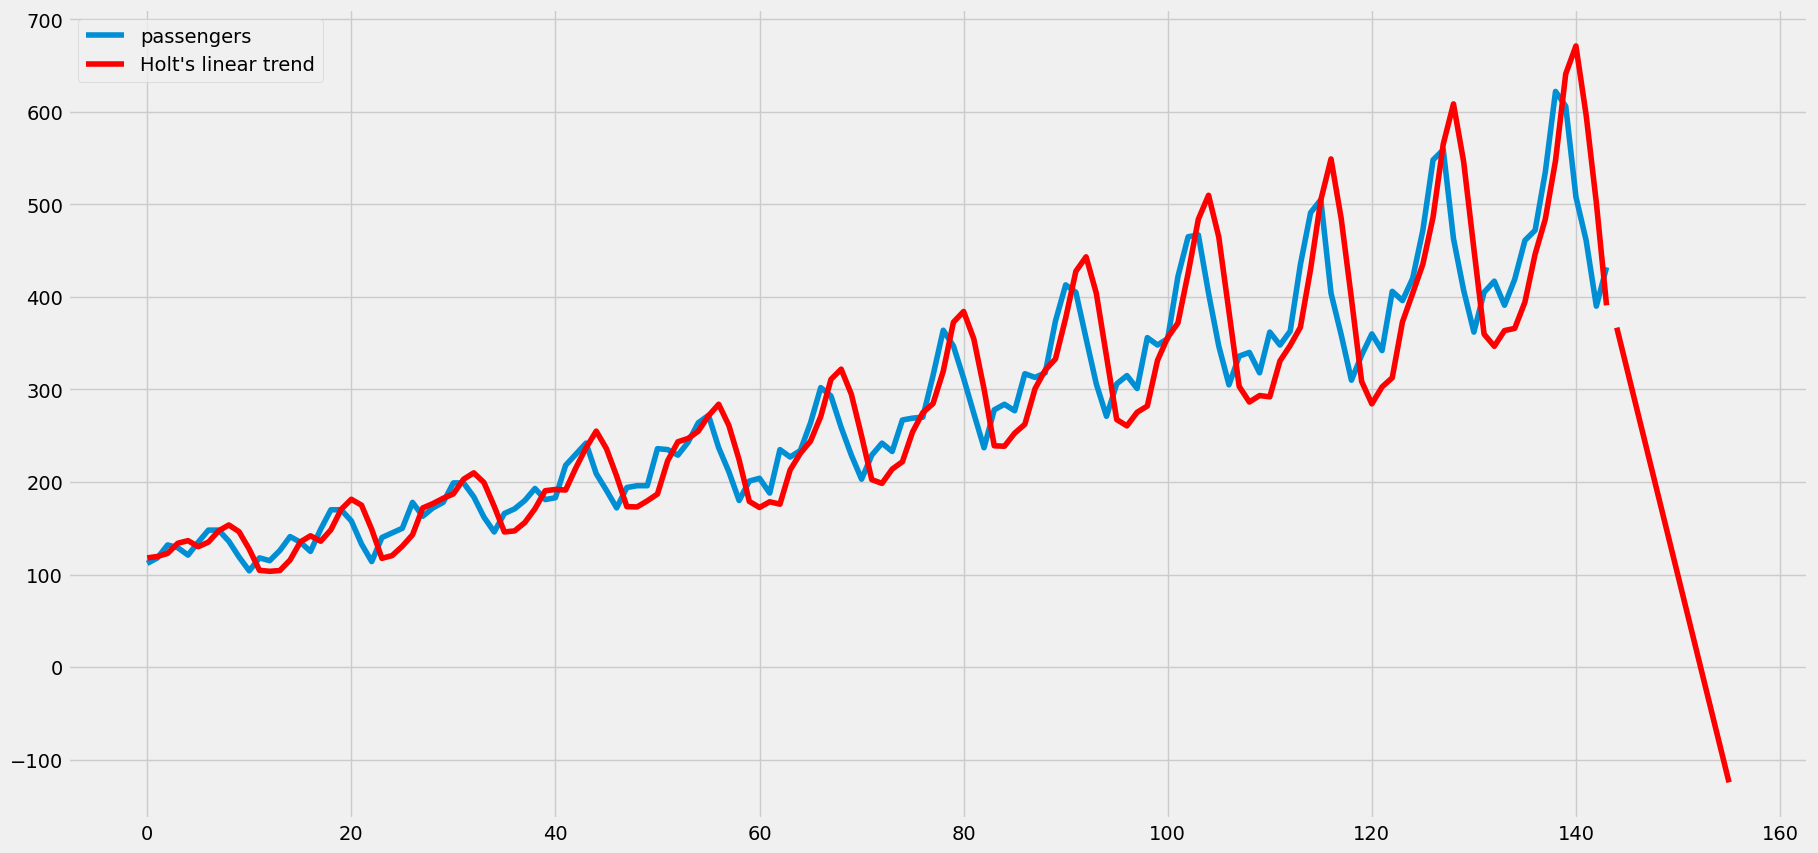

In [7]:
alpha = 0.5
df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

df.plot.line()

fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False) 
# Double smoothing, usando la funcion holt. EL nuevo parametro 'smoothing_slope' se utiliza para la ecuacion de la tendencia
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)

plt.show()

It seems like we are moving in the right direction - the forecast going forward is not constant, but follows a trend. However, it is simply an extrapolation of the most recent (smoothed) trend in the data which means we can expect the forecast to turn negative shortly. This is suspicious in general, and clearly renders the forecast unusable in the domain context.

## Triple Exponential Smoothing
​
If it worked once, maybe it can work twice? A natural extension is to introduce a smoothed seasonal component: triple exponential smoothing, a.k.a. Holt-Winters, is defined by:
​
\begin{equation}
S_t = \alpha (X_t - c_{t - L}) + (1 - \alpha) (S_{t-1} + b_{t-1}) \\
\end{equation}
​
\begin{equation}
b_t = \beta (S_t - S_{t-1}) + (1- \beta) b_{t-1} \\
\end{equation}
​
\begin{equation}
c_t = \gamma (X_t - S_{t-1} - b_{t-1})+ (1 - \gamma) c_{t-L}
\end{equation}
​
with $\alpha, \beta, \gamma \in (0,1)$.
​
The most important addition is the seasonal component to explain repeated variations around intercept and trend, and it will be specified by the period. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week. An obvious, yet worth repeating caveat: it makes sense to estimate seasonality with period $L$ only if your sample size is bigger than $2L$. 
​
The forecast $h$ steps ahead is defined by
\begin{equation}
\hat{X}_{t+h} = S_t + h b_t + c_{(t-L + h) \;\; mod \;\;  L }
\end{equation}

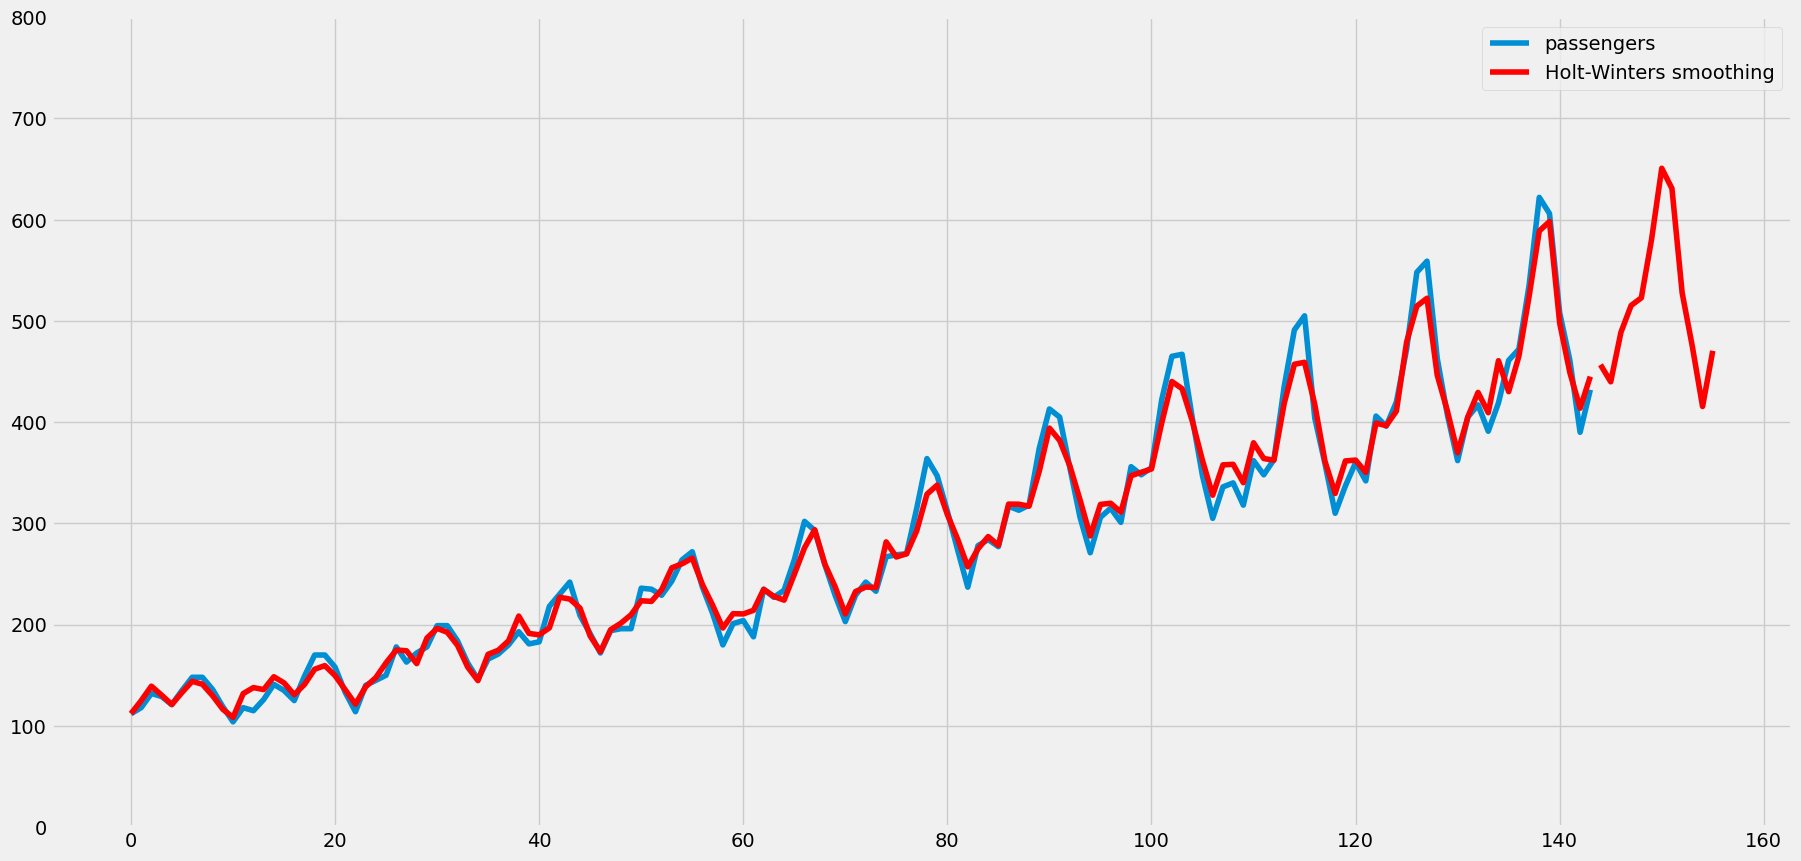

In [15]:
alpha = 0.5
df = pd.read_csv(CFG.data_folder + 'passengers.csv', usecols = ['passengers'])
df.plot.line()
fit1 = ExponentialSmoothing(df, seasonal_periods=12, trend='add', seasonal='add') 
# Para el holt winters usamos trend add y seasonal add. Componente estacional de 12 
fit1 = fit1.fit(smoothing_level=0.5) 
fit1.fittedvalues.plot(color='red') # Graficar los valores estimados
fit1.forecast(12).rename("Holt-Winters smoothing").plot(color='red', legend=True) # Graficar los forecastr

plt.ylim(0, 800); plt.show()

# Anomaly detection

Anomaly detection is a process for identifying unexpected data, event or behavior that require some examination. It is a well-established field within data science and there is a large number of algorithms to detect anomalies in a dataset depending on data type and business context. One of the simplest, yet surprisingly effective ones, is a Z-score. The basic idea is that after suitable normalization, most kinds of data starts behaving like a Gaussian distribution (look up Central Limit Theorem if you would like to understand why) - which implies we only need mean and standard deviation to assess if a given observation is an outlier. Keep in mind that this approach is not 100pct foolproof: there are practical situations when CLT does not work (there's a reason it has a list of assumptions :-) and the Z score will not be meaningful in such circumstances; it does not happen very often, but it is not impossible.


The calculation of the Z-score for each individual point in the series proceeds in the following manner:
* select a window size $w$
* calculate rolling mean / standard deviation with window $w$
* demean and normalize by sd:
\begin{equation}
Z_t = \left|\frac{X_t - \bar{X}_m}{\sigma_m} \right|
\end{equation}

* Z-score measures number of sd away from mean $\implies$ values above 3 indicate extremely unlikely realization

<Axes: >

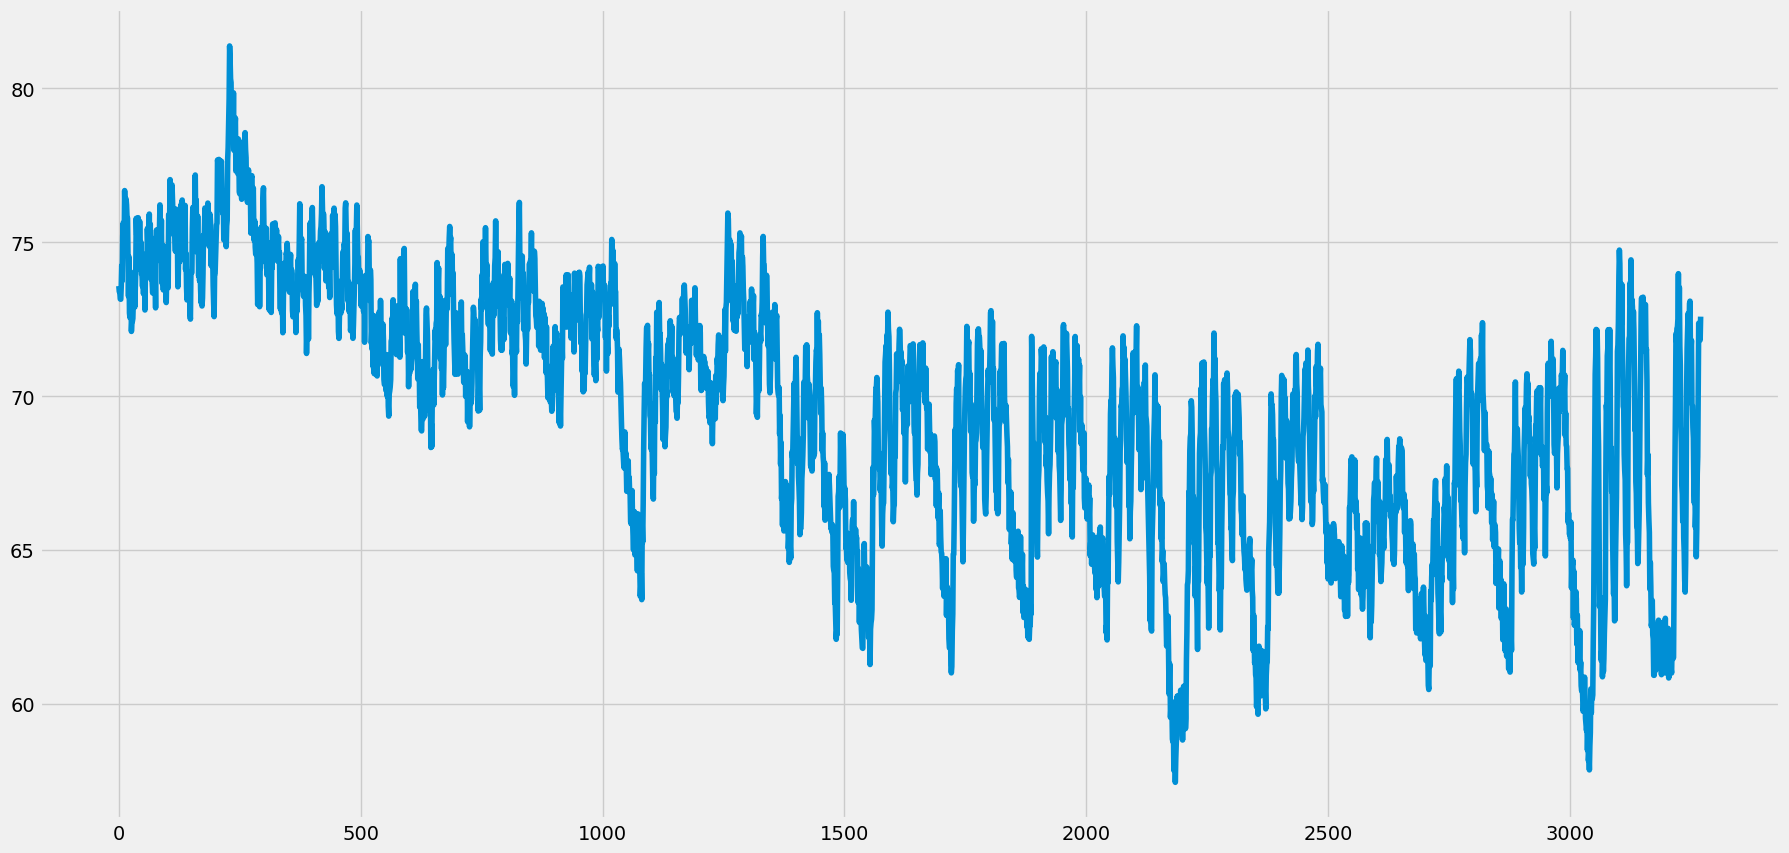

In [16]:
# load 
series = pd.read_csv(CFG.data_folder + 'ambient_temperature_system_failure.csv')
series['timestamp'] = pd.to_datetime(series['timestamp'])  # Volver a datatime la columna timestamp

# plot 
series['value'].plot() # Graficar la colummna value

<Axes: >

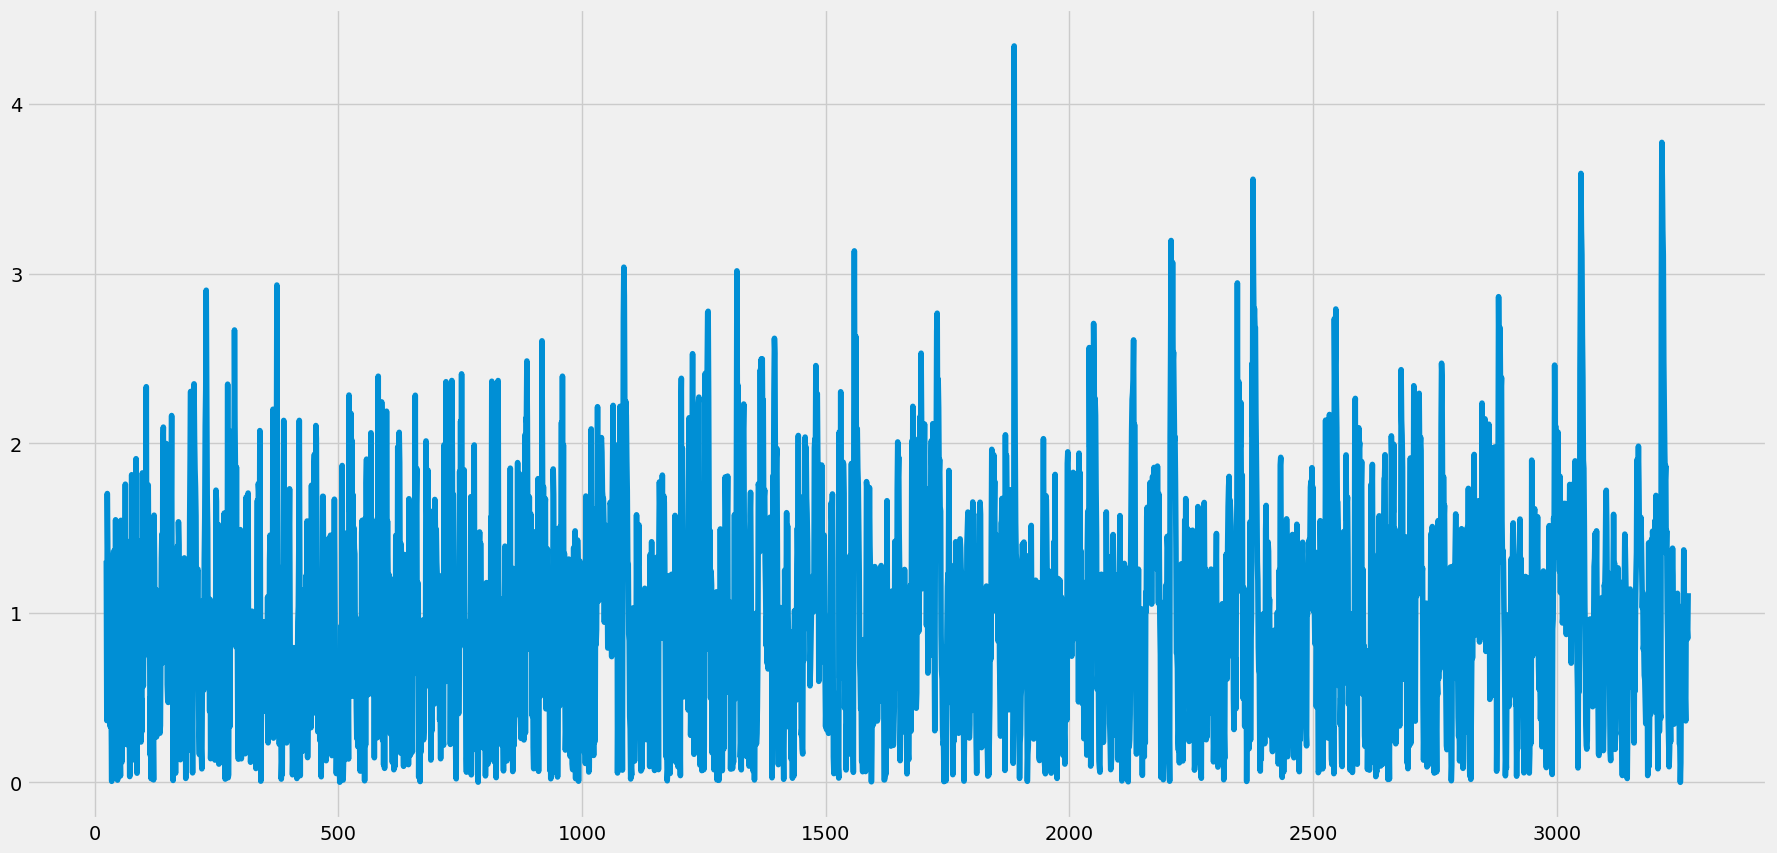

In [21]:
# pick a window size 
window_size = 25

# calculate rolling mean and standard deviation
xroll = series['value'].rolling(window_size) # usar rolling de 25 dias sobre la columna value
series['mean_roll'] = xroll.mean() # hallar la media movil
series['sd_roll'] = xroll.std() # hallar la desviacion estandar movil

# calculate the Z-score
series['zscore'] = np.abs( (series['value'] - series['mean_roll']) / series['sd_roll']) # hallar zvalues
series['zscore'].plot() # Graficarlos

In [22]:
# Encontrar valores de la serie cuyos zvalues sean mayores a 3 desviaciones estandar
series.loc[series['zscore'] > 3][['timestamp', 'value']] # .loc es para seleccionar columnas

,timestamp,value
1086,2014-02-17 13:00:00,69.519207
1318,2014-02-27 05:00:00,69.425502
1559,2014-03-10 11:00:00,67.688348
1887,2014-03-24 19:00:00,71.943363
2209,2014-04-14 10:00:00,63.873030
2212,2014-04-14 13:00:00,66.890486
2377,2014-04-21 10:00:00,64.916813
2378,2014-04-21 11:00:00,65.396986
3050,2014-05-19 11:00:00,66.461085
3051,2014-05-19 12:00:00,68.261759


## Putting it all together

Now that we have all the pieces prepared, we can combine them to build a predictive model. We will use the dataset on daily US energy consumption (in billion kWh)

<Axes: xlabel='date'>

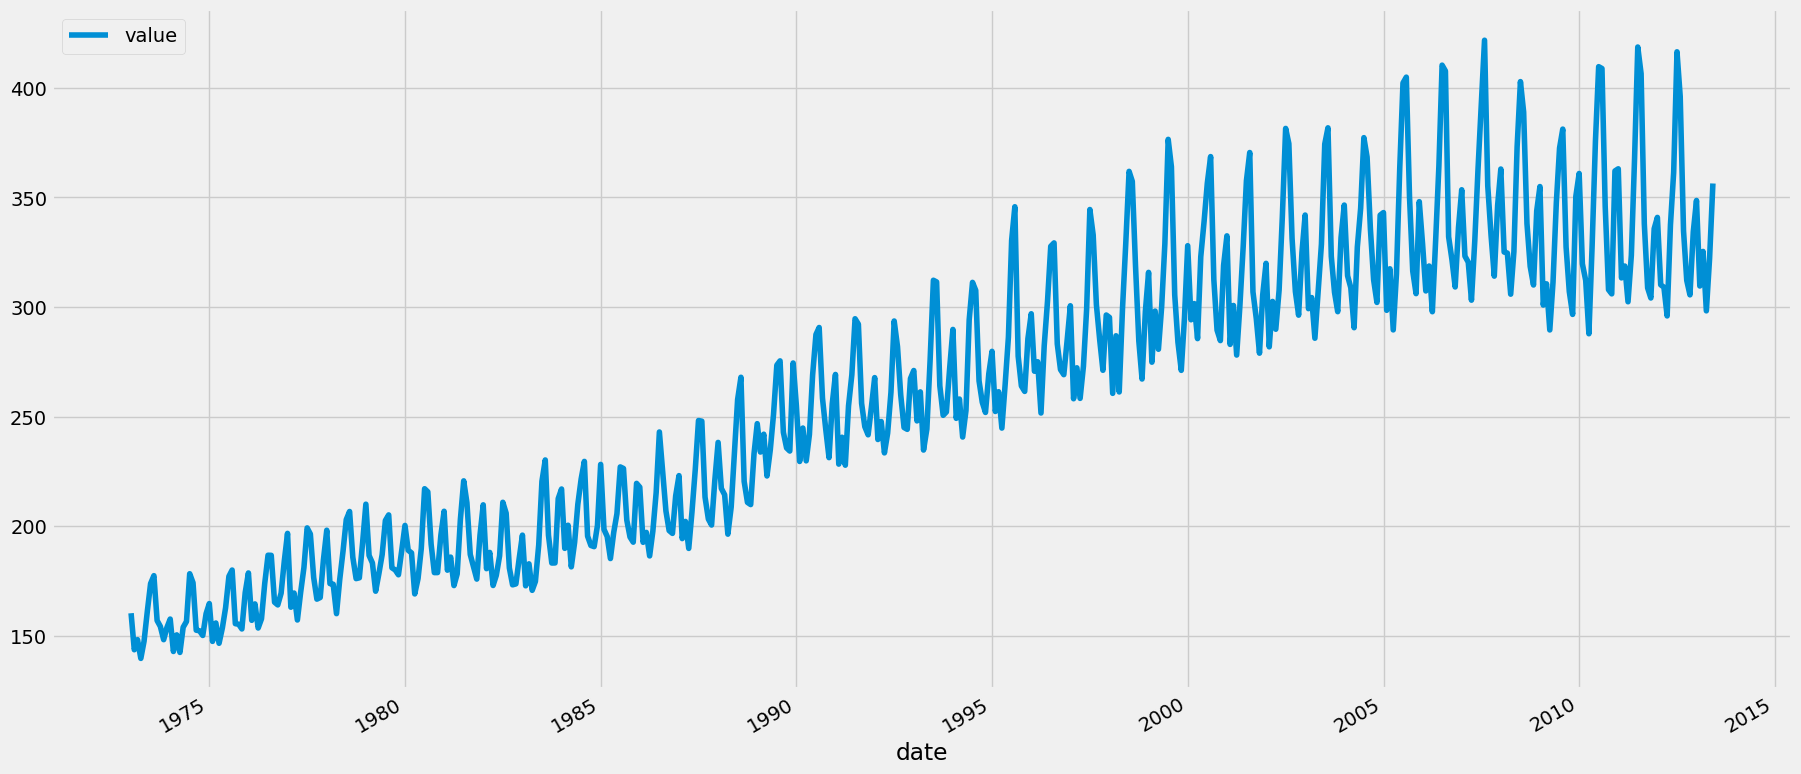

In [23]:
df = pd.read_csv(CFG.data_folder + 'us_energy.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)
df.plot()

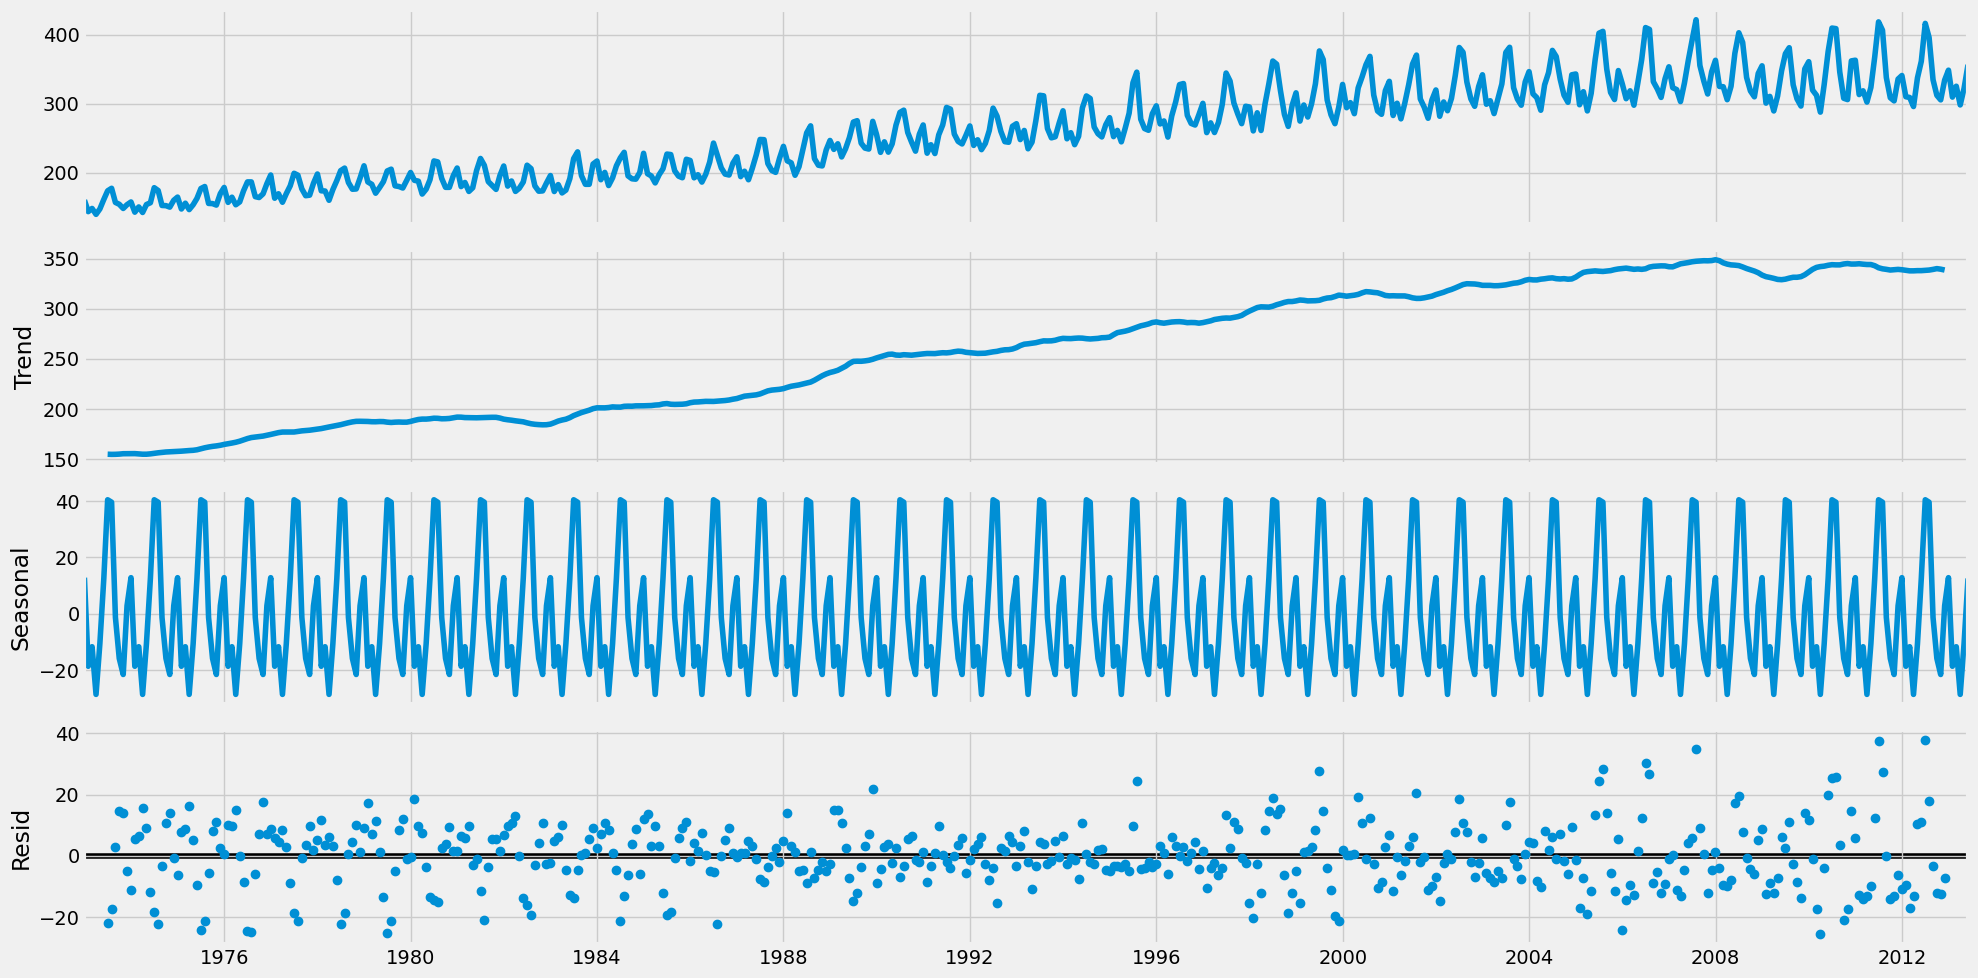

In [24]:
# Realizar descomposicion en componentes de tendencia estacionales y residuales usando la funcion sm.tsa.seasonal_decompose()
decomposition = sm.tsa.seasonal_decompose(df,period =12) 
figure = decomposition.plot()
plt.show()

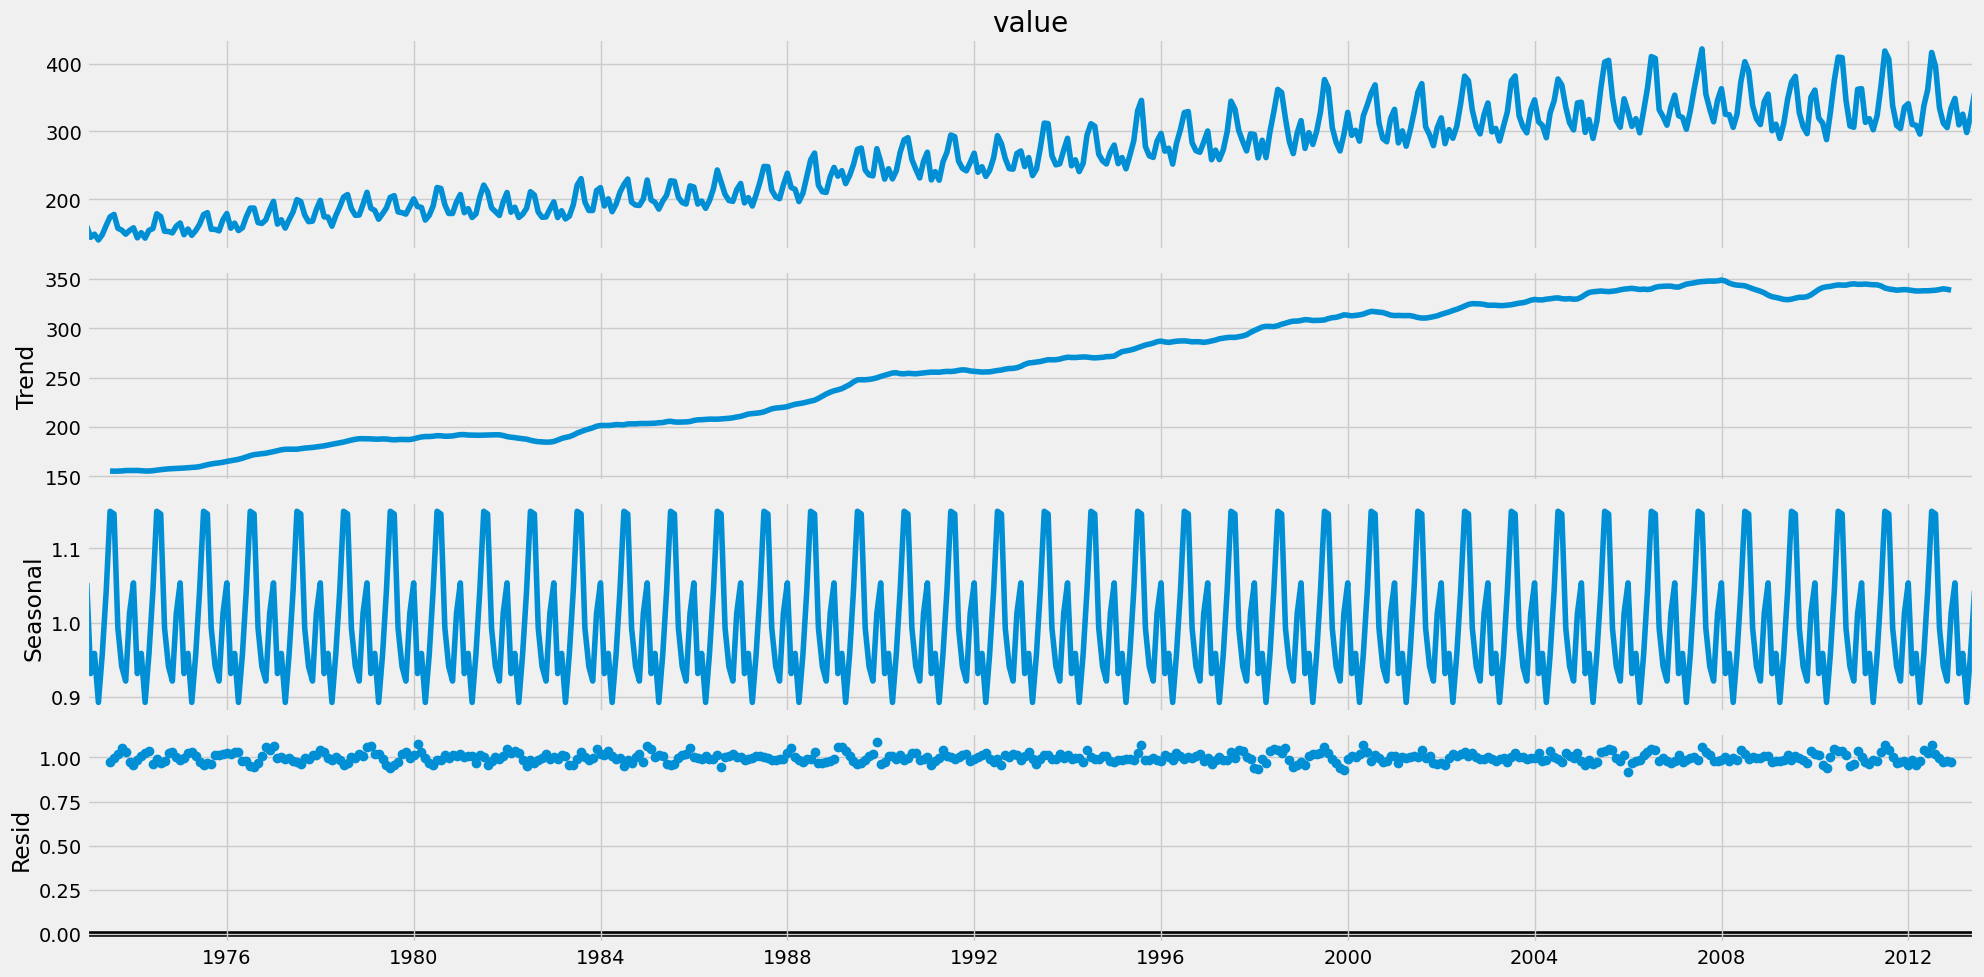

In [25]:
# Ahora con un modelo multiplicativo en vez de uno de adicion
decomposition = sm.tsa.seasonal_decompose(df["value"],period =12, model = 'multiplicative')
figure = decomposition.plot()
plt.show()

It can be observed that:
* There is a clear trend in the data
* There is also a seasonal component
* more stable behavior of the residuals in the second case suggests that a multiplicative decomposition is more appropriate.

Next step: we split the data into training and validation. Our cutoff point will be 2005:


In [26]:
cutoff_date = '2005-12-31'
xtrain, xvalid  = df.loc[df.index <= cutoff_date], df.loc[df.index > cutoff_date]
print(xtrain.shape, xvalid.shape)

(397, 1) (89, 1)


In [28]:
fit1 = ExponentialSmoothing(xtrain['value'].values, seasonal_periods=12, trend='mul', seasonal='mul') 
# modelo de triple smoothing, con modelo multiplicativo tanto en tendencia como en estacional
fit1 = fit1.fit()

C:\Users\jpber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Examining the parameters is fairly straightforward - as you can see, we did not specify the values of the smoothing constants, so they were automatically estimated.

In [29]:
fit1.params_formatted

,name,param,optimized
smoothing_level,alpha,2.817852e-01,True
smoothing_trend,beta,1.870728e-09,True
smoothing_seasonal,gamma,2.263622e-01,True
initial_level,l.0,1.347829e+02,True
initial_trend,b.0,1.001948e+00,True
initial_seasons.0,s.0,1.202624e+00,True
initial_seasons.1,s.1,1.059306e+00,True
initial_seasons.2,s.2,1.087791e+00,True
initial_seasons.3,s.3,1.010855e+00,True
initial_seasons.4,s.4,1.067453e+00,True


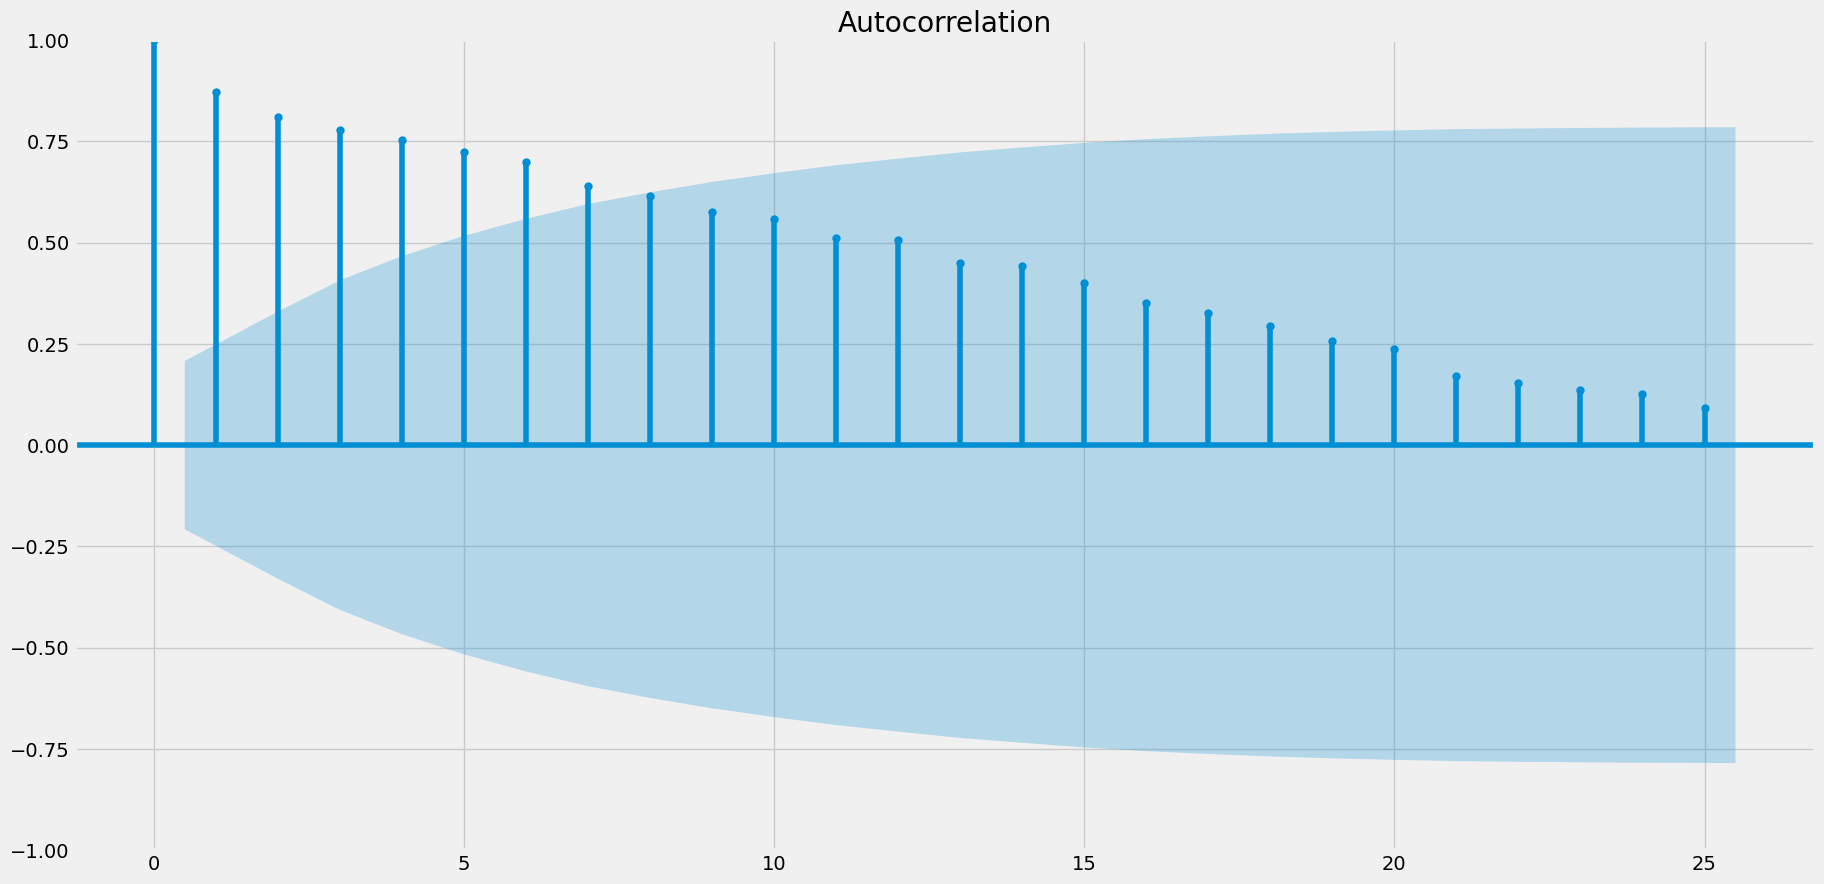

In [30]:
# What do the residuals look like?
prediction = fit1.forecast(len(xvalid)).copy()

xresiduals = xvalid['value'] - prediction
plot_acf(xresiduals, lags = 25)
print()

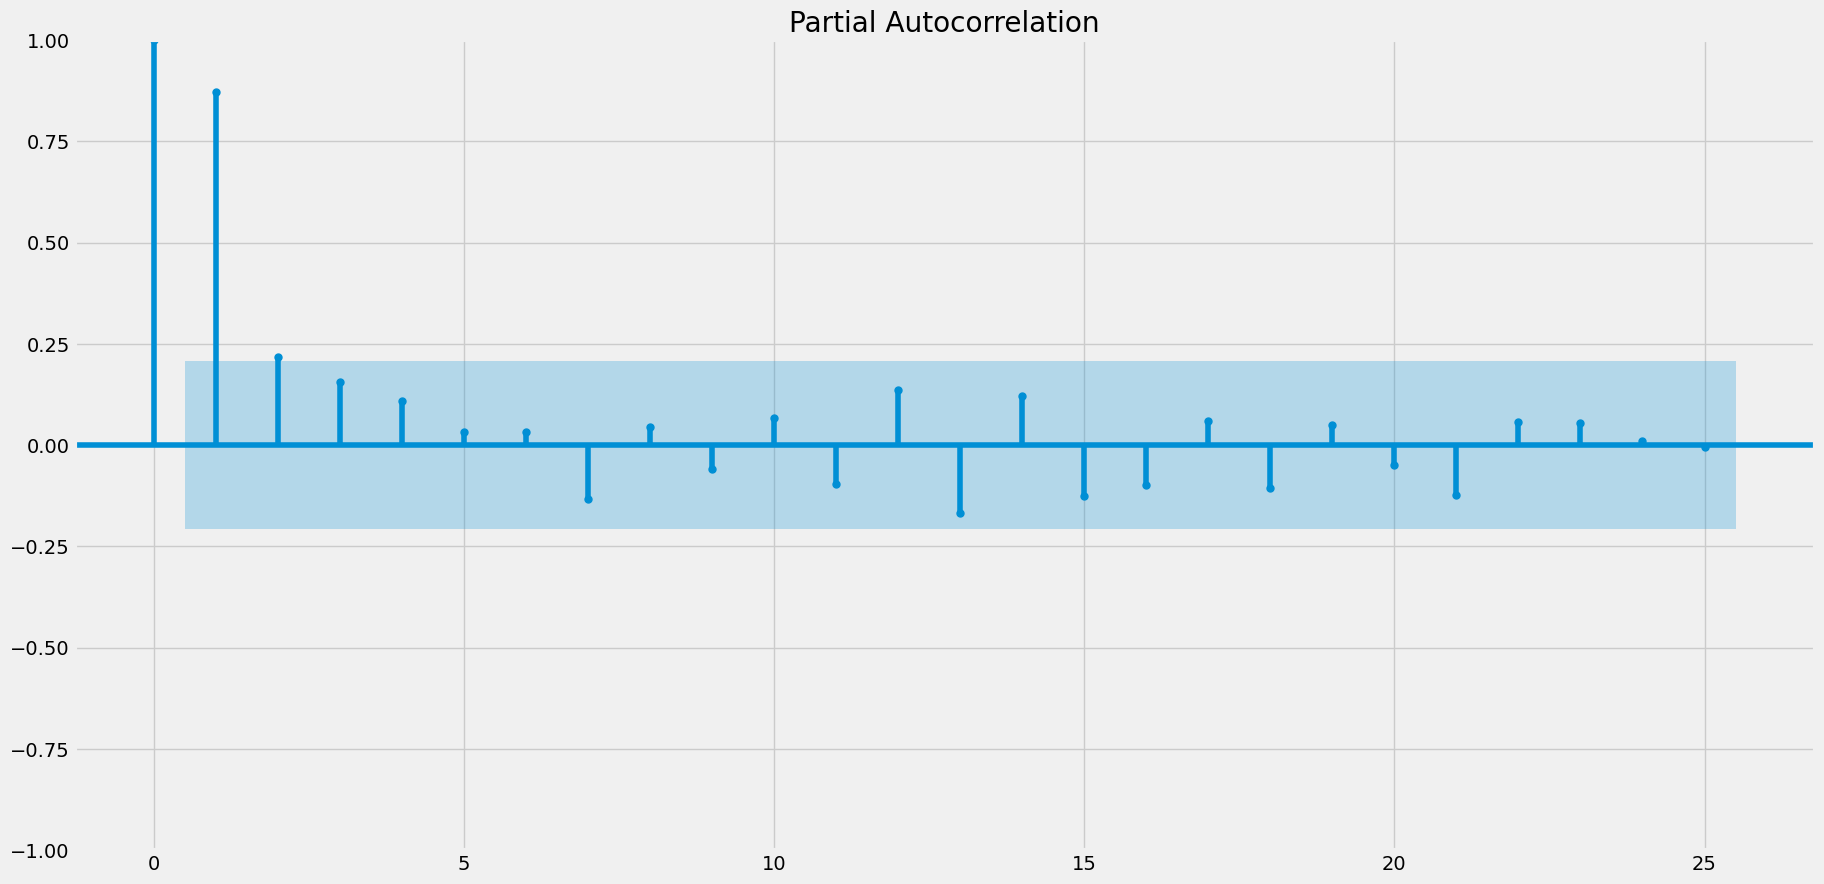

In [31]:
plot_pacf(xresiduals, lags = 25)
print()

The behavior of ACF / PACF (statistically significant autocorrelations) suggests that there is some first- and second-order dependence that our Holt-Winter model cannot capture.

C:\Users\jpber\AppData\Local\Temp\ipykernel_1488\4205454841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvalid['prediction'] = prediction


<Axes: xlabel='date'>

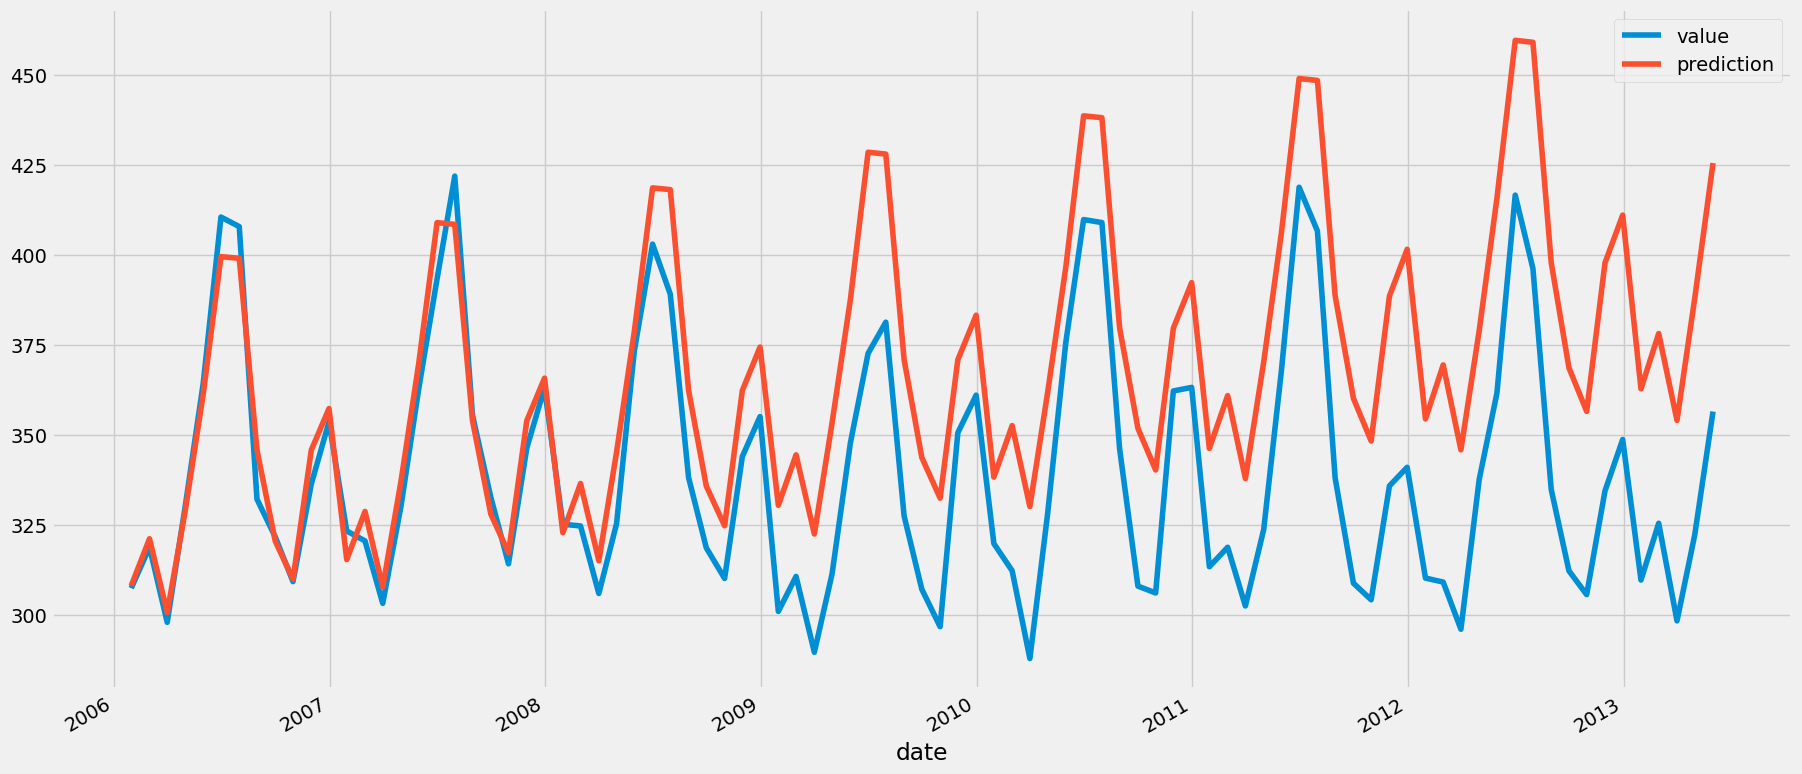

In [32]:
xvalid['prediction'] = prediction
xvalid.plot()

As you can see from the graph above, the model is doing a decent job for the first few years in the sample, but starts to overestimate the consumption afterwards - indicating perhaps a change in the nature of the trend (which would be consistent with the ACF pattern above). This confirms the intuition that there are aspects of the data generating process that are not adequately captured by our three prameter model - but for something that simple, you can make a solid case it is acceptable.